# CCE watershed


In [26]:
watershed = 'CCE'

In [27]:
%matplotlib inline
import pandas as pd
import numpy as np
import datetime as dt
import copy
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [28]:
# some_file.py
#import sys
# insert at 1, 0 is the script path (or '' in REPL)
#sys.path.insert(1, '/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/Functions')
#import Abnormal_data_values_control 
#from Abnormal_data_values_control import threC
import os
os.getcwd()
os.getcwd().rsplit('/',1)[0]

'/Volumes/GoogleDrive/My Drive/DataReleasePaper/ReleaseData/7-CCE'

In [29]:
def nan_groupby(df, method = 'mean', ratio = 0.1): # 0.1*24=2.4 allow 2 hourly missing data points within 24h (one day)
    groupby_df = pd.DataFrame(columns = df.columns)
    for col in df.columns: 
        df_col = df[[col]]
        for group, data in df_col.groupby(df_col.index.date):
            na_rows = data.shape[0] - data.count()[0]
            total_rows = data.shape[0]
            na_ratio = na_rows/total_rows
            if method == 'mean':
                if 0<na_ratio<ratio: # don't want to waste data in this case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean().values[0]
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", data.mean().values[0])
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.mean(skipna = False).values[0]     
            if method == 'sum':
                if 0<na_ratio<ratio: # don't want to waste data case
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = (data.sum().values[0])/(1-na_ratio) # standardize the value
                    print([col,group])
                    print("nan ratio is",na_ratio,", groupby value is", (data.sum().values[0])/(1-na_ratio))
                else:
                    data[col] = pd.to_numeric(data[col], errors='coerce')
                    groupby_df.loc[group,col] = data.sum(skipna = False).values[0]                
    return groupby_df

# function for aggregation(daily) and combination
def aggre_and_comb_daily(lst, axis=1, func = "sum"):
    prep = pd.DataFrame()
    for df in lst:
        if axis == 1:
            if func == "sum":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')
            elif func == "mean":
                prep = prep.join(nan_groupby(df,method = func),how ='outer')        
        elif axis == 0: # concatenate by year
            if func == "sum":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            elif func == "mean":
                prep = pd.concat([prep,nan_groupby(df,method = func)], axis = 0)
            prep.index.rename('DateTime', inplace = True)
        prep = prep[prep.index.notnull()]
    print('The final table is:')
    display(prep.head(2))
    display(prep.tail(2))
    prep.index = pd.to_datetime(prep.index,errors = 'coerce')
    return prep

# a case-by-case function where the threshold values could be changed according with different watersheds
def threC(prep,varname):
# This function returns a dataframe without unrealistic values
# This function only deletes unrealistic data, doesn't deal with the outliers
# SR avg is 1361 W/m2 for earth, could be net solar radiation so include negative values  
    thre_dic = {'Discharge':(0,9999999),  # comment here is the threshold values are changed for this case
                'Precipitation':(0,9999), 
                'AirTemperature':(-20,50),
                'SolarRadiation':(-50,1361),
                'RelativeHumidity': (0,100), 
                'WindDirection': (0,365),
                'WindSpeed': (0, 99),
                'SWE': (0,9999),
                'SnowDepth': (0,9999),
                'VaporPressure': (0,101), 
                'SoilMoisture': (0,100),
                'SoilTemperature': (-50,50), 
                'Isotope': (-9999,9999), 
                'DewPointTemperature': (-100,100), 
                'Snowmelt': (0,9999)
                 }
    thmin = thre_dic[varname][0]
    thmax = thre_dic[varname][1]    
    for i in range(len(prep.columns)):
        col = prep.columns[i]     
        # tranfer the values to be numeric 
        prep[col] = np.array(pd.to_numeric(prep[col], errors='coerce'))        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) < thmin)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0]!=0:     
            print(col,'Out of lower threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)))
            print(col,'Out of lower threshold number:', np.ravel(np.argwhere(np.array(prep[col]) < thmin)).shape[0])        
        prep.iloc[np.ravel(np.argwhere(np.array(prep[col]) > thmax)),i] = np.nan
        if np.ravel(np.argwhere(np.array(prep[col]) >thmax)).shape[0]!=0:
            print(col,'Out of upper threshold indexes:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)))
            print(col,'Out of upper threshold number:', np.ravel(np.argwhere(np.array(prep[col]) > thmax)).shape[0])            
    return prep

###  Streamflow

In [30]:
# USGS 11022480 SAN DIEGO R A MAST RD NR SANTEE CA
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&format=rdb&site_no=11022480&referred_module=sw&period=&begin_date=1912-05-01&end_date=2018-11-29',
                   header = 0,parse_dates = True,skiprows=28,sep = '\t',
                   infer_datetime_format = True)
data.head()

agency_cd   site_no    datetime 7740_00060_00003 7740_00060_00003_cd
0        5s       15s         20d              14n                 10s
1      USGS  11022480  1912-05-01             33.0                   A
2      USGS  11022480  1912-05-02             33.0                   A
3      USGS  11022480  1912-05-03             30.0                   A
4      USGS  11022480  1912-05-04             25.0                   A

In [31]:
data.head()

agency_cd   site_no    datetime 7740_00060_00003 7740_00060_00003_cd
0        5s       15s         20d              14n                 10s
1      USGS  11022480  1912-05-01             33.0                   A
2      USGS  11022480  1912-05-02             33.0                   A
3      USGS  11022480  1912-05-03             30.0                   A
4      USGS  11022480  1912-05-04             25.0                   A

In [32]:
prep = data.drop([0])

In [33]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['7740_00060_00003']))
#prep = copy.deepcopy(data[['nt.dis','bl.dis','bu.dis']])
prep.columns = ['Santee_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)
prep1 = copy.deepcopy(prep)

Santee_Discharge
datetime                    
1912-05-01              33.0
1912-05-02              33.0
1912-05-03              30.0

In [34]:
# USGS 11023000 SAN DIEGO R A FASHION VALLEY AT SAN DIEGO CA
data = pd.read_csv('https://waterdata.usgs.gov/nwis/dv?cb_00060=on&cb_80154=on&cb_80155=on&format=rdb&site_no=11023000&referred_module=sw&period=&begin_date=1982-01-18&end_date=2018-11-20',
                   header = 0,parse_dates = True,skiprows=30,sep = '\t',
                   infer_datetime_format = True)
data.head(2)

agency_cd   site_no    datetime 7745_00060_00003 7745_00060_00003_cd  \
0        5s       15s         20d              14n                 10s   
1      USGS  11023000  1982-01-18             7.60                   A   

  7746_80154_00003 7746_80154_00003_cd 7747_80155_00003 7747_80155_00003_cd  
0              14n                 10s              14n                 10s  
1              NaN                 NaN              NaN                 NaN

In [35]:
prep = copy.deepcopy(data.drop([0]))
prep.index = prep['datetime']
prep = pd.DataFrame(pd.to_numeric(prep['7745_00060_00003']))
#prep = copy.deepcopy(data[['nt.dis','bl.dis','bu.dis']])
prep.columns = ['FashionValley_Discharge']
prep = threC(prep,'Discharge')
display(prep.head(3))
prep.tail(3)
prep2 = copy.deepcopy(prep)

FashionValley_Discharge
datetime                           
1982-01-18                      7.6
1982-01-19                      8.8
1982-01-20                    151.0

In [36]:
prep = pd.concat([prep1,prep2],axis = 1)
prep.head()

Santee_Discharge  FashionValley_Discharge
1912-05-01              33.0                      NaN
1912-05-02              33.0                      NaN
1912-05-03              30.0                      NaN
1912-05-04              25.0                      NaN
1912-05-05              23.0                      NaN

Santee_Discharge
FashionValley_Discharge


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

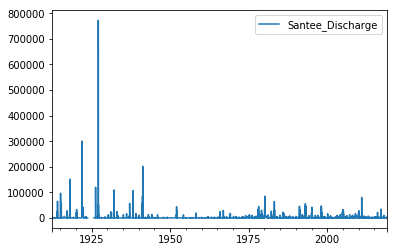

<Figure size 432x288 with 0 Axes>

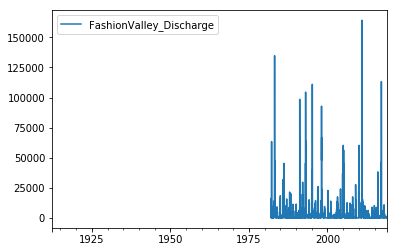

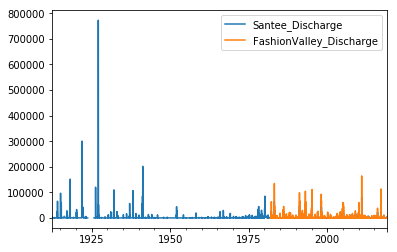

In [37]:
# create a new dataframe and put all the data into it, this is to avoid missing index since the new df has continuous idnex
# check the unit of variable here! Discharge unit should be L/s

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]*28.3168 # convert to L/s
    plt.figure()
    df[[site]].plot()
    
df = threC(df,'Discharge') 
Discharge = copy.deepcopy(df)
Discharge.plot()

### 1. Precipitation

In [38]:
path=os.getcwd().rsplit('/',1)[0]+'/RawData/'
data = pd.read_csv(path + 'San Diego Weather - GHCN Daily.csv',header = 0,parse_dates = True,index_col = 'Date',
                   infer_datetime_format = True)

data.head(2)

Min Temp (C)  Min Temp M Flag  Min Temp Q Flag Min Temp S Flag  \
Date                                                                         
1939-07-01          1.72              NaN              NaN               0   
1939-07-02          1.83              NaN              NaN               0   

            Max Temp (C)  Max Temp M Flag  Max Temp Q Flag Max Temp S Flag  \
Date                                                                         
1939-07-01          2.44              NaN              NaN               0   
1939-07-02          2.33              NaN              NaN               0   

            Avg Temp (C)  Precipitation (mm) Precipitation M Flag  \
Date                                                                
1939-07-01          2.08                 0.0                  NaN   
1939-07-02          2.08                 0.0                  NaN   

            Precipitation Q Flag Precipitation S Flag  \
Date                                                    
1939-07-01                   NaN                    0   
1939-07-02                   NaN                    0   

            Average Wind Speed (m/s)  Average Wind Speed M Flag  \
Date                                                              
1939-07-01                   -9999.0                        NaN   
1939-07-02                   -9999.0                        NaN   

            Average Wind Speed Q Flag Average Wind Speed S Flag  
Date                                                             
1939-07-01                        NaN                       NaN  
1939-07-02                        NaN                       NaN

In [39]:
prep = data[['Precipitation (mm)']]
prep.columns=['Lindberch_Precipitation']

Lindberch_Precipitation


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

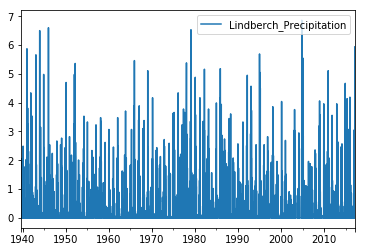

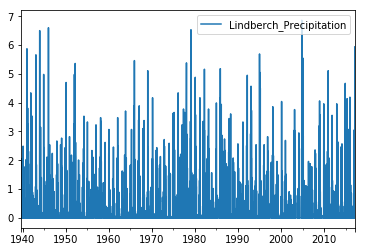

In [40]:
# San Diego Weather
prep = threC(prep,'Precipitation')

indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'Precipitation')     
Precipitation = copy.deepcopy(df)
Precipitation.plot()

### 3. AirTemperature

In [41]:
prep = data[['Avg Temp (C)']]
prep.columns=['Lindberch_AirTemperature']
prep.head(2)

Lindberch_AirTemperature
Date                                
1939-07-01                      2.08
1939-07-02                      2.08

Lindberch_AirTemperature


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

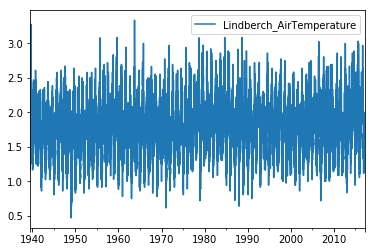

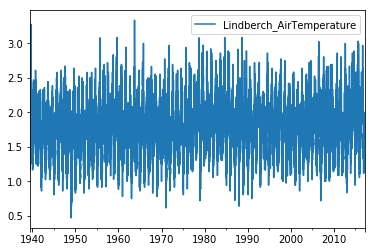

In [42]:
# San Diego Weather
prep = threC(prep,'AirTemperature')
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j]  # convert to the right unit
    plt.figure()
    df[[site]].plot()

df = threC(df,'AirTemperature')   
AirTemperature = copy.deepcopy(df)
AirTemperature.plot()

### 6. WindSpeed

In [43]:
prep = data[['Average Wind Speed (m/s)']]
prep.columns=['Lindberch_WindSpeed']
prep.head(2)

Lindberch_WindSpeed
Date                           
1939-07-01              -9999.0
1939-07-02              -9999.0

Lindberch_WindSpeed


<Figure size 720x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

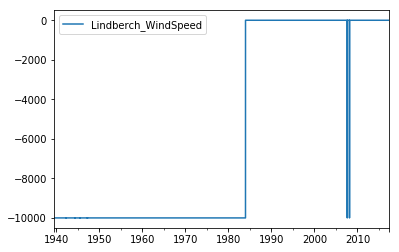

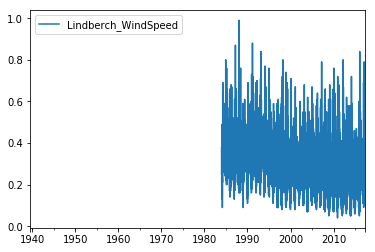

In [44]:
# San Diego Weather (SD)
indexUnique = pd.date_range(str(prep.index[0]), str(prep.index[-1]))  
ready_columns = pd.unique(prep.columns)  
siteList = ready_columns
nan_values = np.nan*np.ones([len(indexUnique),len(ready_columns)])
df = pd.DataFrame(nan_values, index=indexUnique, columns = ready_columns) 

plt.figure(figsize=(10,4))
for i in np.arange(len(ready_columns)):  
    print(siteList[i])            
    site = siteList[i]     
    tab = prep[site]
    for j in np.arange(len(prep)):  
        df.loc[tab.index[j]][ready_columns[i]] = tab[j] 
    plt.figure()
    df[[site]].plot()

df = threC(df,'WindSpeed')  
WindSpeed = copy.deepcopy(df)
WindSpeed.plot()

In [45]:
# Put all the tables to the same date format
# data_soil.index= pd.to_datetime(data_soil.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data.index= pd.to_datetime(data.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S
# data_lwr.index= pd.to_datetime(data_lwr.index, format= '%Y-%m-%d %H:%M:%S').strftime('%Y-%m-%d %H:%M:%S') #%-H:%M:%S

# Bring them together
result1 = pd.concat([Discharge, Precipitation,AirTemperature, WindSpeed],axis=1,
                    join='outer') # discahrge record is too long

In [46]:
result1.index.rename('DateTime', inplace = True)

In [47]:
result1.head(5)

Santee_Discharge  FashionValley_Discharge  \
DateTime                                                
1912-05-01          934.4544                      NaN   
1912-05-02          934.4544                      NaN   
1912-05-03          849.5040                      NaN   
1912-05-04          707.9200                      NaN   
1912-05-05          651.2864                      NaN   

            Lindberch_Precipitation  Lindberch_AirTemperature  \
DateTime                                                        
1912-05-01                      NaN                       NaN   
1912-05-02                      NaN                       NaN   
1912-05-03                      NaN                       NaN   
1912-05-04                      NaN                       NaN   
1912-05-05                      NaN                       NaN   

            Lindberch_WindSpeed  
DateTime                         
1912-05-01                  NaN  
1912-05-02                  NaN  
1912-05-03                  NaN  
1912-05-04                  NaN  
1912-05-05                  NaN

In [48]:
result1.tail()

Santee_Discharge  FashionValley_Discharge  \
DateTime                                                
2018-11-25         15.291072                      NaN   
2018-11-26         14.441568                      NaN   
2018-11-27         14.441568                      NaN   
2018-11-28         14.724736                      NaN   
2018-11-29       3086.531200                      NaN   

            Lindberch_Precipitation  Lindberch_AirTemperature  \
DateTime                                                        
2018-11-25                      NaN                       NaN   
2018-11-26                      NaN                       NaN   
2018-11-27                      NaN                       NaN   
2018-11-28                      NaN                       NaN   
2018-11-29                      NaN                       NaN   

            Lindberch_WindSpeed  
DateTime                         
2018-11-25                  NaN  
2018-11-26                  NaN  
2018-11-27                  NaN  
2018-11-28                  NaN  
2018-11-29                  NaN

In [49]:
# Write data to csv for further inspection
result1.to_csv('1_CCE_Download_Aggregation_Daily.csv', sep=',')